# Linear Regression (Gradient Descent)





So far we have looked at direct matrix method for solving the $Ax = b$ problem. But most machine learning algorithms may not be directly computatable. So the alternative way to do is to define a cost function that needs to be minimised and use a gradient descent approach to solve it.

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
pop = pd.read_csv('data/cars_small.csv')
pop.head()

,brand,model,price,kmpl,bhp,type
0,Chevrolet,Beat,421,18.6,79,Hatchback
1,Chevrolet,Sail,551,18.2,82,Sedan
2,Chevrolet,Sail Hatchback,468,18.2,82,Hatchback
3,Chevrolet,Spark,345,16.2,62,Hatchback
4,Fiat,Linea Classic,612,14.9,89,Sedan


## Solving using Sklearn 

In [4]:
from sklearn import linear_model
from sklearn import metrics

In [5]:
X = pop['kmpl'].values.reshape(-1,1)
y = pop['price']

In [6]:
model = linear_model.LinearRegression(fit_intercept=True)
model.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [7]:
model.coef_

array([-36.12619236])

In [8]:
beta0 = round(model.intercept_)
beta1 = round(model.coef_[0])
print("b0 = ", beta0, "b1 =", beta1)

b0 =  1158.0 b1 = -36.0


## Plotting the Regression Line 

$$ price = 1158 - 36 * kmpl ~~~~ \textit{(population = 42)}$$ 


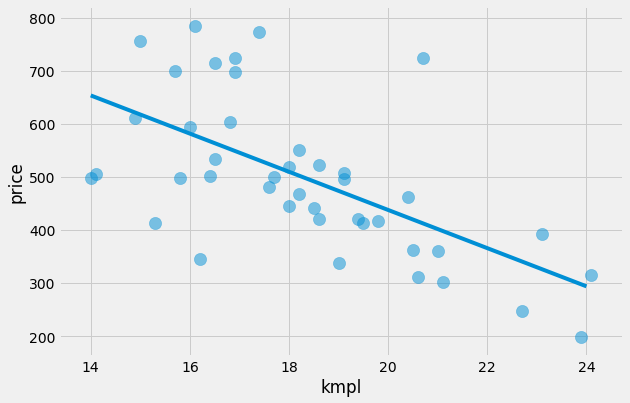

In [9]:
x = np.arange(min(pop.kmpl),max(pop.kmpl),1)

plt.xlabel('kmpl')
plt.ylabel('price')

y_p = beta0 + beta1 * x
plt.plot(x, y_p, '-')
plt.scatter(pop.kmpl, pop.price, s = 150, alpha = 0.5 )

## Calculating the Error term

The error term as we saw is defined as:

$$ E(\beta)=   \frac {1}{n} {||y - X\beta||}^2 $$

In [10]:
# Solving using Ax = b approach
n = pop.shape[0]
x0 = np.ones(n)
x1 = pop.kmpl
X = np.c_[x0, x1]
X = np.asmatrix(X)
y = np.asmatrix(pop.price.values.reshape(-1,1))
b = np.asmatrix([[beta0],
                 [beta1]])

In [11]:
# Error calculation
def error_term(X,y,b,n):
    M = (y - X*b)
    error = M.T*M / n
    return error[0,0]

In [12]:
round(error_term(X,y,b,n))

13065.0

## Shape of the error term

Lets plot the error term and see that the error surface is **CONVEX**. And there is one absolute minimum point.

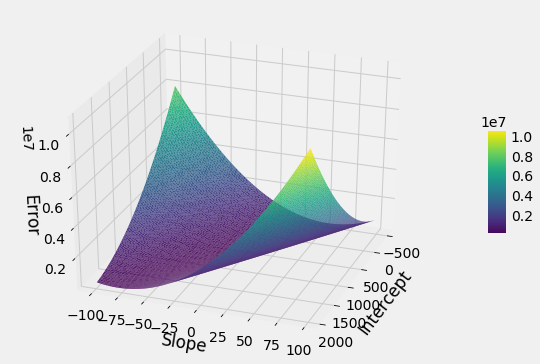

In [14]:
# Calculate a range of values for b0 and b1
b0_min, b0_max = -500, 2000
b1_min, b1_max = -100, 100
bb0, bb1 = np.meshgrid(np.arange(b0_min, b0_max, (b0_max - b0_min)/100), 
                       np.arange(b1_min, b1_max, (b1_max - b1_min)/100))

# Calculate a mesh of values for b0 and b1 and error term for each
bb = np.c_[bb0.ravel(), bb1.ravel()]
errors = [error_term(X,y,np.asmatrix(i).T,n) for i in bb]

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
trisurf = ax.plot_trisurf(bb[:,0], bb[:,1], errors, cmap=plt.cm.viridis, linewidth=0)

ax.view_init(azim=20)
fig.colorbar(trisurf, shrink=0.3, aspect=5)

ax.set_xlabel('Intercept')
ax.set_ylabel('Slope')
ax.set_zlabel("Error")

Let's plot the error term as a 2D plot - as a **contour plot** and make it more clear.

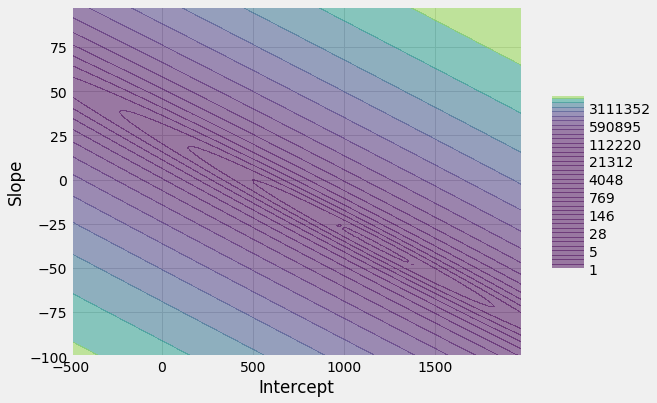

In [15]:
# Get the errors
Z = np.asmatrix(errors).reshape(bb0.shape)

# Get the contour
e_min, e_max = np.min(errors), np.max(errors)
levels = np.logspace(0, np.log10(e_max), 40)

# Plot the contour
fig = plt.figure()
cs = plt.contourf(bb0, bb1, Z, cmap=plt.cm.viridis, levels = levels, linewidth=0.3, alpha = 0.5)
fig.colorbar(cs, shrink=0.5, aspect=5)

plt.xlabel('Intercept')
plt.ylabel('Slope')

## Gradient Descent 

In our linear regression problem, there is only one minimum. Our error surface is convex. So we can start from one point on the error surface and gradually move down in the error surface in the direction of the minimum.

"At a theoretical level, gradient descent is an algorithm that minimizes the cost functions. Given a cost function defined by a set of parameters, gradient descent starts with an initial set of parameter values and iteratively moves toward a set of parameter values that minimize the cost function. This iterative minimization is achieved using calculus, taking steps in the negative direction of the function gradient."

So the gradient in linear regression is:
$$ \nabla E(\beta)=  \frac {2}{n} X^T(X\beta−y) $$

Lets start at an arbitary point for the features (0,0) and calculate the gradient




In [16]:
b_initial = np.asmatrix([[500],
                      [-100]])

In [17]:
def gradient(X,y,b,n):
    g = (2/n)*X.T*(X*b - y)
    return g

In [18]:
error_term(X,y,b_initial,n)

3371573.9285714286

In [19]:
gradient(X,y,b_initial,n)

matrix([[ -3651.28571429],
        [-67557.49047619]])

In [20]:
b_next = b_initial - 0.01 * gradient(X,y,b_initial,n)
b_next

matrix([[ 536.51285714],
        [ 575.57490476]])

## Learning Rate and Epochs

Now we need to update our parameters in the direction of the gradient. And keep repeating the process. 

$$ \beta_{i+1} = \beta_{i} - \eta * \nabla E(\beta)$$


- Learning rate ($\eta$) - how far we need to move towards the gradient in each step
- Epoch - Number of times we want to execute this process

In [29]:
def gradient_descent (eta, epochs, X, y, n):
    
    # Set Initial Values 
    b = np.asmatrix([[-250],[-50]])
    e = error_term(X,y,b,n)
    b0s, b1s, errors = [], [], []
    b0s.append(b.item(0)) 
    b1s.append(b.item(1)) 
    errors.append(e)

    # Run the calculation for those many epochs
    for i in range(epochs):
        g = gradient(X,y,b,n)
        b = b - eta * g
        e = error_term(X,y,b,n)
        
        b0s.append(b.item(0)) 
        b1s.append(b.item(1)) 
        errors.append(e)
    
    print('error =', round(errors[-1]), ' b0 =', round(b0s[-1]), 'b1 =', round(b1s[-1]))
          
    return errors, b0s, b1s

Lets see the error rate with different Learning Rate and Epochs

In [35]:
errors, b0s, b1s = gradient_descent (0.001, 100, X, y, n)

error = 48985.0  b0 = -240 b1 = 39


### Exercise

Try with learning rate = 0.001, Epochs = 1000

Try with learning rate = 0.02, Epochs = 1000

Try with learning rate = 0.001, Epochs = 50000

## Plotting Epochs and Learning Rate

In [38]:
def plot_gradient_descent(eta, epoch, gradient_func):
    
    es, b0s, b1s = gradient_func(eta, epoch, X, y, n)
    
    # Plot the intercept and coefficients
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    #plt.tight_layout()
    
    # Plot the contour
    cs = plt.contourf(bb0, bb1, Z, cmap=plt.cm.viridis, levels = levels, 
                      linewidth=0.3, alpha = 0.5)
    
    # Plot the intercept and coefficients
    plt.plot(b0s, b1s, '-b', linewidth = 2)
    plt.xlim([-500,2000])
    plt.ylim([-100,100])
    plt.xlabel('Intercept')
    plt.ylabel('Slope')
    
    # Plot the error rates
    plt.subplot(1, 2, 2)
    plt.plot(np.log10(es))
    plt.ylim([3,10])
    plt.xlabel('Epochs')
    plt.ylabel('log(Error)')       

error = 49239.0  b0 = -245 b1 = 39


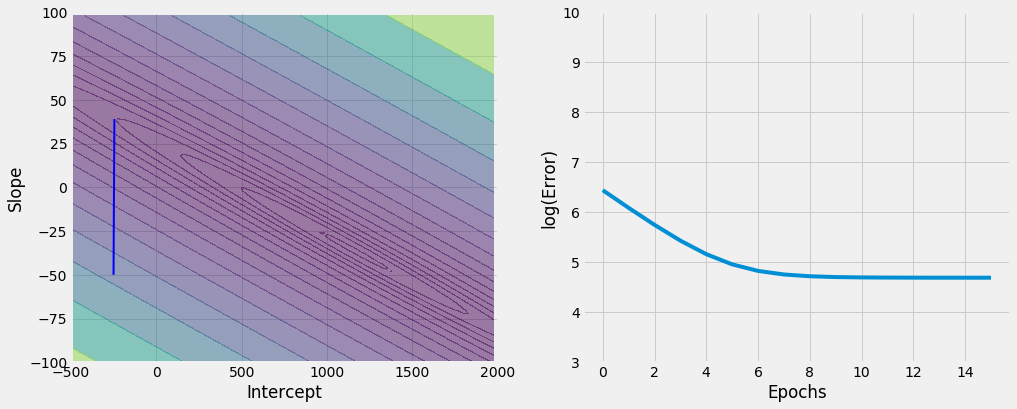

In [39]:
plot_gradient_descent(0.0005, 15, gradient_descent)

### Exercise
Plot with learning rate = 0.001, Epochs = 1000

Plot with learning rate = 0.005, Epochs = 10000

Plot with learning rate = 0.001, Epochs = 50000

## Challenges with Simple Gradient Descent


#### Convexity
In our linear regression problem, there was only one minimum. Our error surface was convex. Regardless of where we started, we would eventually arrive at the absolute minimum. In general, this need not be the case. It’s possible to have a problem with local minima that a gradient search can get stuck in. There are several approaches to mitigate this (e.g., stochastic gradient search).

#### Performance 
We used vanilla gradient descent with a learning rate of 0.001 in the above example, and ran it for 50000 iterations. There are approaches such a line search, that can reduce the number of iterations required and also avoid the overshooting problem with large learning rate.

#### Convergence 
We didn’t talk about how to determine when the search finds a solution. This is typically done by looking for small changes in error iteration-to-iteration (e.g., where the gradient is near zero).

## Line Search Gradient Descent

To avoid the problem of setting the learning rate and overshooting, we can adaptively choose the step size

$$ \beta_{i+1} = \beta_{i} - \eta * \nabla E(\beta)$$


First, fix a parameter $ 0 < \gamma < 1$, then start with $\eta = 1$, and while


$$ E(\beta_{i+1}) >  E(\beta) - \frac{\eta}{2} * {||\nabla E(\beta)||}^2 $$

then

$$ \eta = \gamma * \eta $$

Typically, we take $\gamma = [0.1, 0.8] $

In [64]:
def gradient_descent_line (eta, epochs, X, y, n):
    
    gamma = 0.5
        
    # Set Initial Values 
    b = np.asmatrix([[-250],[-50]])
    es = error_term(X,y,b,n)
    b0s, b1s, errors = [], [], []
    b0s.append(b.item(0)) 
    b1s.append(b.item(1)) 
    errors.append(es)

    # Run the calculation for those many epochs
    for i in range(epochs):
        es_old = error_term(X,y,b,n)
        g = gradient(X,y,b,n)
        b = b - eta * g
        es = error_term(X,y,b,n)
        #print(e,e_old)
        if es > es_old - eta/2*(g.T*g):
            eta = eta * gamma
        
        b0s.append(b.item(0)) 
        b1s.append(b.item(1)) 
        errors.append(es)
    
    print('error =', round(errors[-1]), ' b0 =', round(b0s[-1]), 'b1 =', round(b1s[-1]))

    return errors, b0s, b1s

### Avoid Overshooting
Let see the performance difference between Simple Gradient Descent and Line Search Gradient Descent

In [65]:
errors, b0s, b1s = gradient_descent_line (1, 50000, X, y, n)

error = 13928.0  b0 = 940 b1 = -24


In [66]:
errors, b0s, b1s = gradient_descent (0.0005, 50000, X, y, n)


error = 18845.0  b0 = 597 b1 = -6


### Plotting the Line Search Gradient Descent

error = 28314.0  b0 = 247 b1 = 13


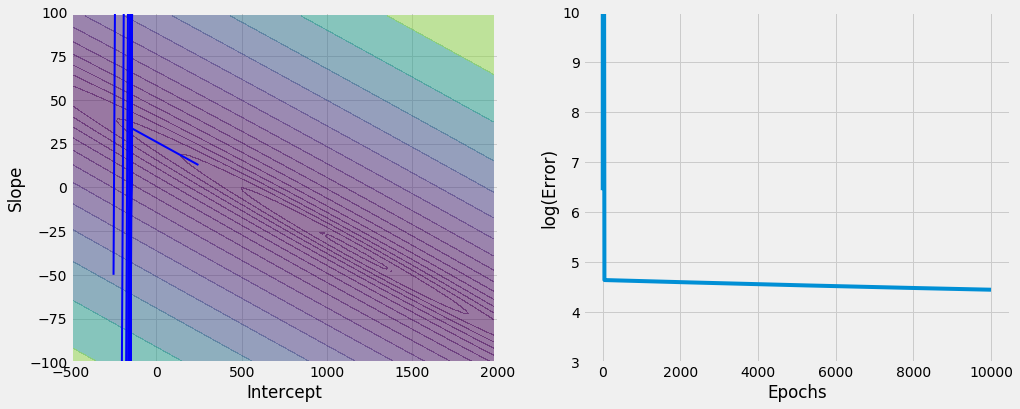

In [68]:
plot_gradient_descent(1, 10000, gradient_descent_line)